### Setup

In [77]:
import os
import sys
import itertools
import math

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from arch import arch_model, unitroot
import warnings
warnings.warn = lambda *a, **kw: False

import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as scs
from stldecompose import decompose, forecast

sys.path.append("..") # Adds higher directory to python modules path for importing from src dir
from src.datasets import NyseStocksDataset, NyseSecuritiesDataset
import src.econometric_utils as eco
import src.regression_utils as regr
import src.plot_utils as plot
import src.math_utils as math_utils

split = lambda x: (x.iloc[:600], x.iloc[600:])  # train: 2010-01-05 until 2012-05-21, val: 2012-05-21 until 2012-12-31

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 349 ms


In [4]:
stocks = NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices-split-adjusted.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close'], load=True, look_back=1)
securities = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv', load=True)


time: 13.2 s


In [5]:
gspc = stocks.load_gspc().set_index('date')[['gspc_open', 'gspc_close']].rename(lambda x: x.replace('gspc_', ''), axis=1)
gspc = eco.add_movements(gspc)

vix = stocks.load_vix().set_index('date')[['vix_open', 'vix_close']].rename(lambda x: x.replace('vix_', ''), axis=1)
vix = eco.add_movements(vix)

prices = stocks.enhance_features(stocks.prices.copy())
comp_prices = []
comp_grouped = prices.groupby(prices.symbol, sort=False)
for sym, p in tqdm(comp_grouped):
    comp_prices.append(stocks.shape_company_data(p))

gspc_train = gspc.lret.iloc[:600]
gspc_val = gspc.lret.iloc[600:]
vix_train = vix.lret.iloc[:600]
vix_val = vix.lret.iloc[600:]


time: 9.98 s


### Which timespan is more stable?

"Open-to-open returns are more volatile than close-to-close returns"
("Trading and Returns Under Periodic Market Closures", Hong and Wang, 1998)

"Blandon (2007) shows that while close-to-close stock returns are
highly autocorrelated, daily returns calculated on an open-to-close basis do not
exhibit significant levels of autocorrelation. Amihud and Mendelson (1987) and
Stoll and Whaley (1990) report that the interday stock returns computed using
open-to-open prices have greater variance and show more evidence of reversals
than comparable returns computed from close-to-close prices"
("Informational Content of Open-to-Close Stock Returns", Andrey Kudryavtsev)

"Our results show that the open-to-open interday variance of HSI is higher than the closeto-close interday variance on all weekdays except Monday" ("Intraday and intraweek volatility patterns of Hang Seng Index and index futures, and a test of the wait-to-trade hypothesis.", Tang, 2002)

For testing the trading day hypothesis (returns are generated only during active trading and the expected return is the same for each trading day of the week): "When opening data are available, calculating trading
day returns from open to close is preferable to close to close" ("New Findings Regarding Day-of-the-Week Returns over Trading and Non-Trading Periods: A Note", Rogalski, 1984)

"The absence of autocorrelation in stock return on an open-to-close basis supports
Rogalski (1984) findings regarding the importance of distinguishing between trading
and non-trading daily returns." ("Return autocorrelation anomalies in two European stock markets", Blandon, 2007)

I can approve the assertion by Lockwood1990 (https://sci-hub.se/10.2307/2328672) that the volatility is higher for intraday than overnight stock returns.

"There is considerable empirical evidence that return dynamics are different over non-trading periods than during trading periods (French and Roll, 1986; Lockwood and Linn, 1990; Hasbrouck, 1991, 1993; and Madhavan et al., 1997; George and Wang, 2001; Cliff et al., 2008)" ("Information Flows Around the Globe: Predicting Opening Gaps from Overnight Foreign Stock Price Patterns", Gooijer, 2012)

- 467 stock prices from S&P 500 index
    - open-to-open:
        - AC1: $\mu = -0.0224, \sigma = 0.0569$
        - AC1 without Monday: $\mu = -0.0203, \sigma = 0.0566$
        - STD: $\mu =  0.0185, \sigma = 0.0055$
        - Overall STD: $0.0193$
    - close-to-close:
        - AC1: $\mu = -0.0399, \sigma = 0.0515$
        - AC1 without Monday: $\mu = -0.0215, \sigma = 0.0484$
        - STD: $\mu =  0.0188, \sigma = 0.0056$
        - Overall STD: $0.0196$
    - open-to-close:
        - AC1: $\mu = -0.0260, \sigma = 0.0554$
        - AC1 without Monday: $\mu = -0.0083, \sigma = 0.0529$
        - STD: $\mu =  0.0155, \sigma = 0.0046$
        - Overall STD: $0.0161$
- GSPC
    - open-to-open:
        - AC1: $-0.0359$
        - STD: $0.0112$
    - close-to-close:
        - AC1: $-0.0732$ $\implies$ exceeds 5\% significance level
        - STD: $0.0117$
    - open-to-close:
        - AC1: $-0.0771$ $\implies$ exceeds 5\% significance level
        - STD: $0.0111$
- VIX
    - open-to-open:
        - AC1: $-0.1196$ $\implies$ exceeds 5\% significance level
        - STD: $0.0731$
    - close-to-close:
        - AC1: $-0.0839$ $\implies$ exceeds 5\% significance level
        - STD: $0.0757$
    - open-to-close:
        - AC1: $-0.0547$
        - STD: $0.0592$

AC 5% Significant level: $\pm \frac{1.96}{\sqrt{T - d}} = \pm \frac{1.96}{\sqrt{753 - 1}} = \pm 0.0715$  $\implies$  no statistically significant autocorrelation present

Only when considering the total close-to-close daily return, both VIX and GSPC are significantly autocorrelated with lag 1. One reason for this increased correlation in comparison to open-to-close (intraday) can be the additional information of the end of the previous day which is carried by the last close price. Additionally, the overnight return reflects those information of the previous day (TODO: cite).

Taking the log of the returns, ensures a zero mean while obtaining other properties. In fact, it changes the standard deviation and auto correlation values only by a very small difference. When subtracting one for each original return value, the Kolmogorov-Smirnov test cannot reject its null and therefore confirms that the data distribution is still the same after taking the log.

In [ ]:
acf = lambda x, l: math_utils.auto_correlation(x, range(l))
statistics = pd.DataFrame([{'oto_ac1': acf(cdata.oto, 2)[1], 'oto_std': cdata.oto.std(),
  'ctc_ac1': acf(cdata.ctc, 2)[1], 'ctc_std': cdata.ctc.std(),
  'otc_ac1': acf(cdata.otc, 2)[1], 'otc_std': cdata.otc.std()} for cdata in comp_prices])
# Inspect monday: "[x[x.date.dt.weekday != 0] for x in comp_prices]""

print ("AUTO CORRELATION (lag=1)")  # Inspect Auto Correlation with lag=1
print('oto:', statistics.oto_ac1.mean().round(4), statistics.oto_ac1.std().round(4))
print('ctc:', statistics.ctc_ac1.mean().round(4), statistics.ctc_ac1.std().round(4))
print('otc:', statistics.otc_ac1.mean().round(4), statistics.otc_ac1.std().round(4))
print('gspc oto:', acf(gspc.oto, 2)[1].round(4))
print('gspc ctc:', acf(gspc.ctc, 2)[1].round(4))
print('gspc otc:', acf(gspc.otc, 2)[1].round(4))
print('vix oto:', acf(vix.oto, 2)[1].round(4))
print('vix ctc:', acf(vix.ctc, 2)[1].round(4))
print('vix otc:', acf(vix.otc, 2)[1].round(4))

print ("STANDARD DEVIATION")  # Inspect Standard deviation
print('oto:', statistics.oto_std.mean().round(4), statistics.oto_std.std().round(4))
print('ctc:', statistics.ctc_std.mean().round(4), statistics.ctc_std.std().round(4))
print('otc:', statistics.otc_std.mean().round(4), statistics.otc_std.std().round(4))
print('gspc oto:', gspc.oto.std().round(4))
print('gspc ctc:', gspc.ctc.std().round(4))
print('gspc otc:', gspc.otc.std().round(4))
print('vix oto:', vix.oto.std().round(4))
print('vix ctc:', vix.ctc.std().round(4))
print('vix otc:', vix.otc.std().round(4))

### Transformations

Shapiro test (null=normal): p value = 0.0000
Shapiro test (null=normal): p value = 0.0000
Shapiro test (null=normal): p value = 0.0000

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 1.0000
>Kruskal-Wallis (null = equal): p value = 0.9394
>Mann-Whitney (null = equal): p value = 0.4697

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 0.0158
>Kruskal-Wallis (null = equal): p value = 0.9839
>Mann-Whitney (null = equal): p value = 0.4920


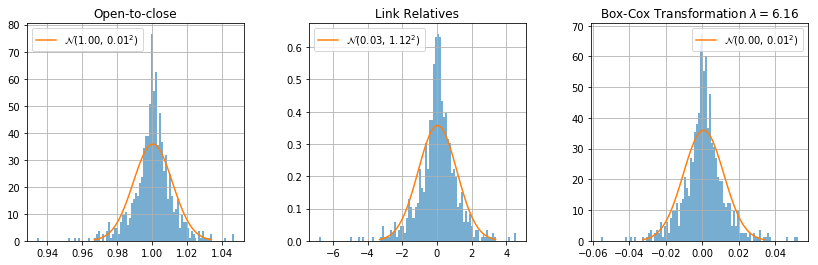

time: 1.53 s


In [416]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot.compare_with_normal(gspc.otc, 'Open-to-close', ax=axes[0])
plot.compare_with_normal(gspc.lret, 'Link Relatives', ax=axes[1])
plot.compare_with_normal(orig_boxcox_values, fr'Box-Cox Transformation $\lambda={argmll_lmbda:.2f}$', ax=axes[2])
regr.compare_distributions(gspc.otc - 1, gspc.lret / 100)
regr.compare_distributions(boxcox_values, gspc.lret / 100)

Shapiro test (null=normal): p value = 0.0000
Shapiro test (null=normal): p value = 0.0016


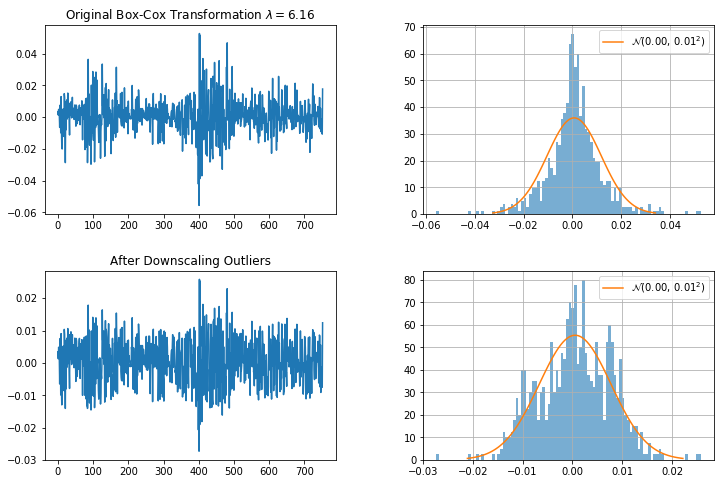

time: 1.27 s


In [414]:
orig_boxcox_values, argmll_lmbda = stats.boxcox(gspc.otc)
boxcox_values = orig_boxcox_values.copy()
outliers = np.abs(boxcox_values) > 0.01
outliers2 = np.abs(boxcox_values) > 0.02
boxcox_values[outliers] *= 0.7
boxcox_values[outliers2] *= 0.7
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].set_title(fr'Original Box-Cox Transformation $\lambda={argmll_lmbda:.2f}$')
axes[0, 0].plot(orig_boxcox_values)
plot.compare_with_normal(orig_boxcox_values, ax=axes[0, 1], title=' ')

axes[1, 0].set_title('After Downscaling Outliers')
axes[1, 0].plot(boxcox_values)
plot.compare_with_normal(boxcox_values, ax=axes[1, 1], title=' ')

### Test Regression Analysis on GSPC
https://www.kaggle.com/benjibb/prototype-gspc

More on tests and their intuitions: http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/3-8-UnivarGoF.html

Test for Unit Root:
>Augmented Dickey-Fuller (null = I(1)): p value = 0.0000
>KPSS (null = I(0)): p value = 0.9317
>Phillips-Perron (null = I(1)): p value = 0.0000

Test for Autocorrelation:
>Durbin-Watson (null(2) = no autocorr., lag 1): statistic = 2.1711
>Ljung-Box-Q (null = no autocorr., lag 1): p value = 0.03

Test for Normal Distribution:
>Jarque-Bera (null = gaussian): p value = 0.0000
>Shapiro-Wilk (null = gaussian): p value = 0.0000
>D’Agostino’s K^2 (null = gaussian): p value = 0.0000
>Anderson-Darling (null = gaussian): p value = 0.0000

Test for Structural Breaks:
>CUSUM test on OLS residuals (null = stable coeff): p value = 0.9626


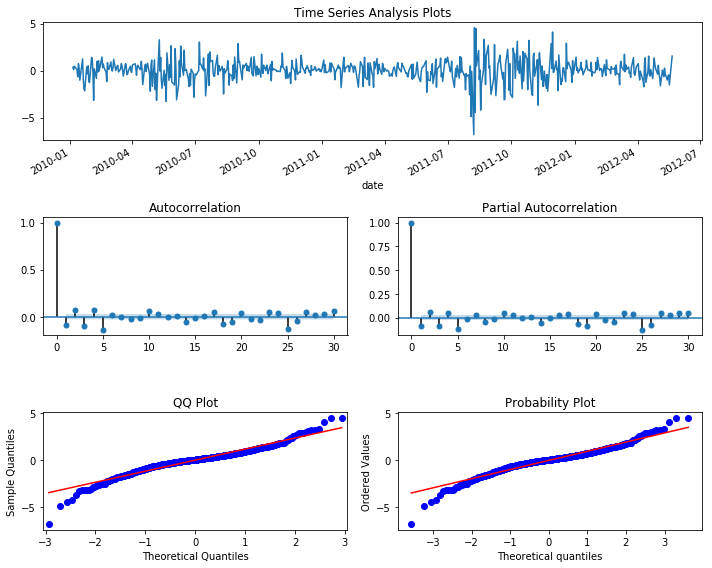

time: 1.58 s


In [7]:
plot.tsplot(gspc_train);
regr.investigate(gspc_train, verbose=True);

In [33]:
print(unitroot.ADF(gspc_train).regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     147.8
Date:                Fri, 29 Mar 2019   Prob (F-statistic):          1.74e-101
Time:                        09:34:57   Log-Likelihood:                -932.46
No. Observations:                 595   AIC:                             1877.
Df Residuals:                     589   BIC:                             1903.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -1.1864      0.096    -12.312      0.0

### Seasonality

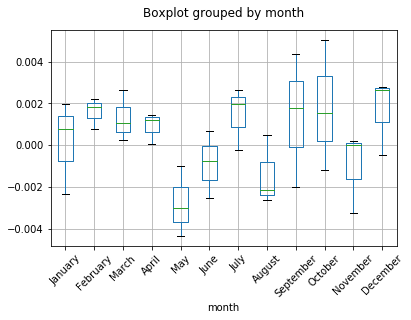

time: 500 ms


In [103]:
plot.boxplot_monthly(gspc.open.pct_change())

- https://medium.com/@a.nejad_99199/exploring-market-seasonality-trends-19a91381c0fe
- https://github.com/anejad/Exploring-Market-Seasonality-Trends/blob/master/Exploring%20Seasonality%20Trends%20in%20Stock%20Market.ipynb
- https://otexts.com/fpp2/components.html
- https://towardsdatascience.com/analysis-of-stock-market-cycles-with-fbprophet-package-in-python-7c36db32ecd0
- https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?article=2030&context=jmasm

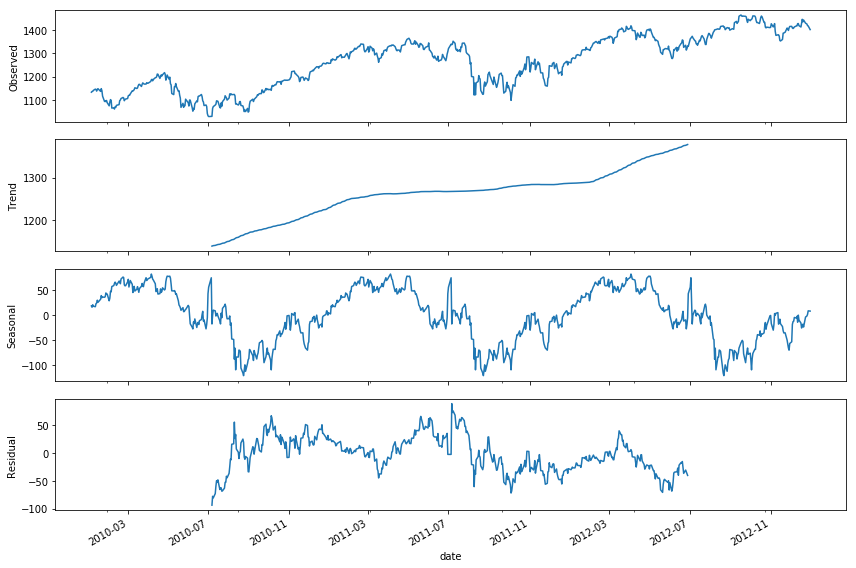

time: 853 ms


In [545]:
regr.inspect_seasonality(gspc.open);

#### Whole data

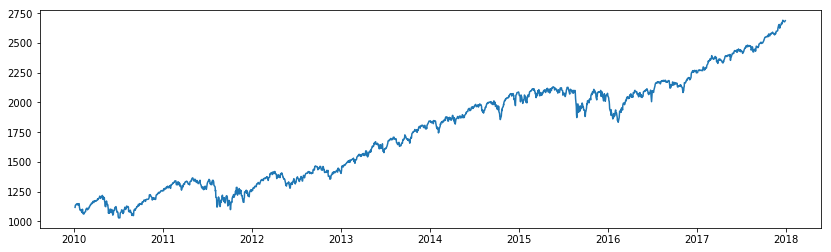

time: 746 ms


In [89]:
gspc_all = pd.read_csv(os.path.join(stocks.file_dir, 'gspc.csv')).reset_index(drop=True)
gspc_all = gspc_all.set_index(pd.to_datetime(gspc_all.Date, errors='coerce')).drop('Date', axis=1)
gspc_all = gspc_all[gspc_all.index.year != 2018]

plt.subplots(figsize=(14, 4))
plt.plot(gspc_all[gspc_all.index.year >= 2010].Open);

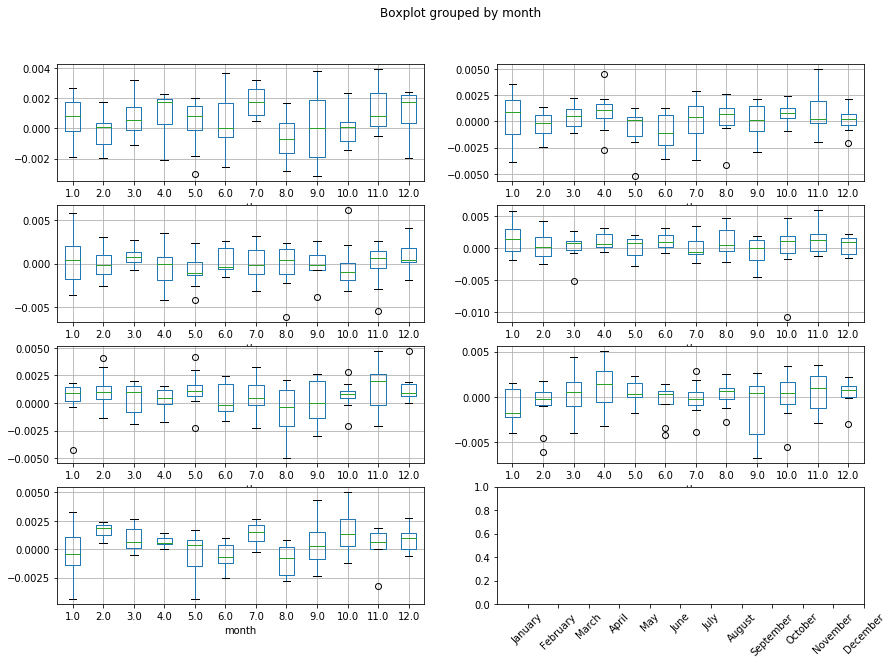

time: 6.53 s


In [102]:
years = list(range(1950, 2011, 10))
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

for ax, year in zip(axes.flat, years):
    r = gspc_all[pd.Series(gspc_all.index.year, index=gspc_all.index).between(year, year+9)].Open.pct_change()
    plot.boxplot_monthly(r, ax=ax)

In [51]:
amounts_of_trading_days = gspc_all.groupby(gspc_all.index.year).count().groupby('Open').count()
# Usually 252 or 253 days

time: 274 ms


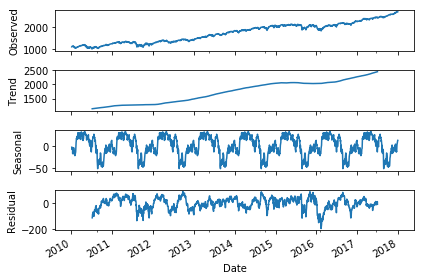

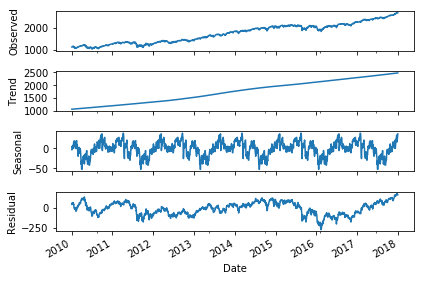

time: 1.5 s


In [108]:
r = gspc_all[gspc_all.index.year >= 2010].Open
# r = r.pct_change().fillna(0)

res = smt.seasonal_decompose(r, model='additive', freq=252)
res.plot();

res2 = decompose(r)
res2.plot();

### Develop & Fit ARIMA

In [242]:
model = smt.ARIMA(gspc_train, order=(1, 0, 1))
model_fit = model.fit(method='mle', trend='nc', update_freq=5)
in_sample_predictions = model_fit.predict()

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                   lret   No. Observations:                  600
Model:                     ARMA(1, 1)   Log Likelihood                -942.180
Method:                           mle   S.D. of innovations              1.163
Date:                Fri, 29 Mar 2019   AIC                           1890.361
Time:                        12:49:52   BIC                           1903.551
Sample:                             0   HQIC                          1895.496
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.lret    -0.8260      0.079    -10.439      0.000      -0.981      -0.671
ma.L1.lret     0.7399      0.093      7.975      0.000       0.558       0.922
                                    Roots           

In [248]:
history = list(gspc_train)
ex_sample_predictions = pd.DataFrame(0, columns=['value', 'std', 'confLow', 'confUp'], index=gspc_val.index)
for t in tqdm(range(len(gspc_val))):
    _model = smt.ARIMA(history, order=(1, 0, 1))
    _model_fit = _model.fit(method='mle', trend='nc', update_freq=5, disp=0)
    guess, std, confs = _model_fit.forecast()
    ex_sample_predictions.iloc[t] = (guess, std[0], *confs[0])
    history.append(gspc_val[t])


time: 19.8 s


ARIMA(1, 0, 1), RMS =  1.1634
Persistence Model, RMS =  1.7342
Shapiro test (null=normal): p value = 0.0000


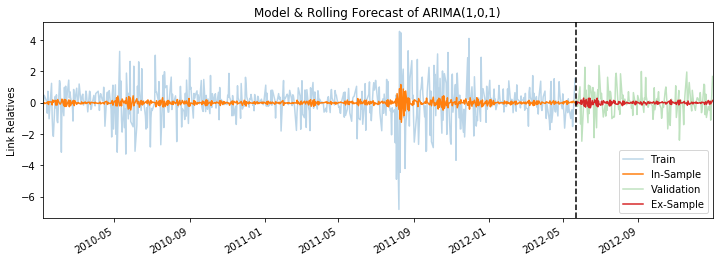

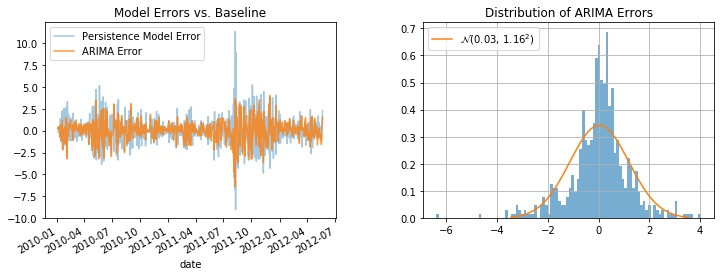

time: 1.23 s


In [267]:
ax = gspc_train.plot(label='Train', alpha=0.3, title='Model & Rolling Forecast of ARIMA(1,0,1)', figsize=(12, 4))
ax.plot(gspc_train.index, in_sample_predictions, label='In-Sample')
gspc_val.plot(ax=ax, label='Validation', alpha=0.3)
ex_sample_predictions.value.plot(ax=ax, label='Ex-Sample')
plt.xlim((gspc_train.index[0], gspc_val.index[-1]))
plt.axvline(gspc_val.index[0], color='black', linestyle='dashed')
ax.legend()
ax.set_ylabel('Link Relatives')
ax.set_xlabel('');
# plt.gcf().savefig('gspc - arima101.pdf')


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

print('ARIMA(1, 0, 1), RMS = ', round(np.sqrt(mean_squared_error(gspc_train, in_sample_predictions)), 4))
print('Persistence Model, RMS = ', round(np.sqrt(mean_squared_error(gspc_train, gspc_train.shift(1).fillna(0))), 4))

axes[0].plot(gspc_train - gspc_train.shift(1), alpha=0.4, label='Persistence Model Error')
(gspc_train - in_sample_predictions).plot(ax=axes[0], alpha=0.8, label='ARIMA Error')
axes[0].legend()
axes[0].set_title('Model Errors vs. Baseline');

plot.compare_with_normal(model_fit.resid, title='Distribution of ARIMA Errors', ax=axes[1])

### Develop & fit GARCH

In [625]:
class ARIMA_GARCH():
    def __init__(self, data, p=1, d=0, q=1, r=3, s=3):
        self.arima = smt.ARIMA(data, order=(p, d, q))
        self.arima_fit = self.arima.fit(method='mle', trend='nc', update_freq=5)
        # Use ARIMAs residuals
        self.garch = arch_model(self.arima_fit.resid, mean='Zero', vol='GARCH', p=r, q=s)
        self.garch_fit = self.garch.fit(update_freq=5, disp='off')
        self.in_sample_predictions = model_fit.conditional_volatility
        self.p, self.d, self.q, self.r, self.s = p, d, q, r, s
        # fig = res.plot(annualize='D')
        # sms.het_arch(res.resid / res.conditional_volatility)
        # am = arch_model(train, p=1, o=0, q=1, dist='StudentsT', vol='EGARCH')
    
    def predict_volatility(self):
        yhat = self.garch_fit.forecast()
        return yhat.variance.iloc[-1][0]

    def __str__(self):
        return f'{self.arima.__class__.__name__}({self.p}, {self.d}, {self.q})-{model.garch.volatility.__class__.__name__}({self.r}, {self.s})'

time: 164 ms


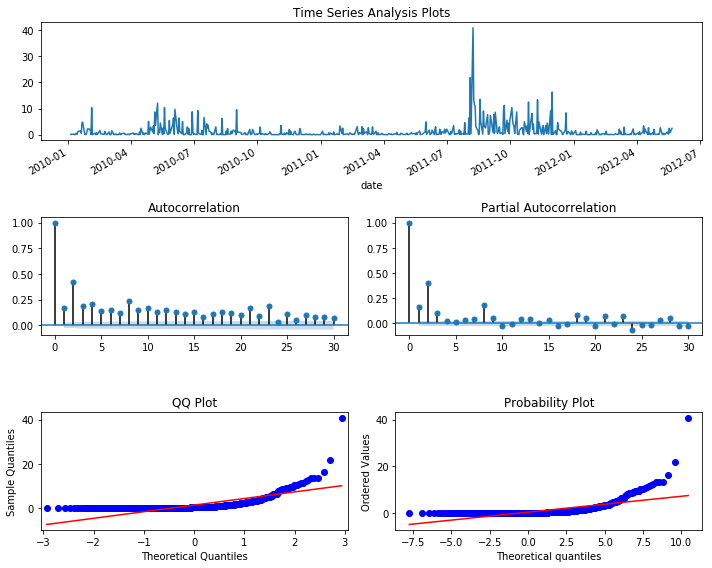

time: 946 ms


In [589]:
model = ARIMA_GARCH(gspc_train, 1, 0, 1, 1, 1)
regr.tsplot(model.arima_fit.resid**2);

In [561]:
# Result from last block: PACF is considerable until lag=3
p, q = 3, 3  # p = lagged variance, q = lagged residuals
model = ARIMA_GARCH(gspc_train, 1, 0, 1, p, q)
print(model.garch_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -839.790
Distribution:                  Normal   AIC:                           1693.58
Method:            Maximum Likelihood   BIC:                           1724.36
                                        No. Observations:                  600
Date:                Fri, Mar 29 2019   Df Residuals:                      593
Time:                        18:05:47   Df Model:                            7
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0687  3.230e-02      2.127  3.346e-02 

In [581]:
history = list(gspc_train)
ex_sample_predictions = pd.Series(0.0, index=gspc_val.index)
for t in tqdm(range(len(gspc_val))):
    temp_model = ARIMA_GARCH(history, 1, 0, 1, p, q)
    ex_sample_predictions[t] = temp_model.predict_volatility()
    history.append(gspc_val[t])


time: 25.7 s


In [609]:
final_model = ARIMA_GARCH(pd.concat([gspc_train, gspc_val]), 1, 0, 1, p, q)

# There is no real volatility - this is an approximations we're using for comparison
gspc_train_volatility = model.arima_fit.resid.rolling(p).std(ddof=0)
gspc_train_volatility[:p-1] = gspc_train_volatility[p-1]  # Due to rolling window fill nones with last actual value
gspc_val_volatility = final_model.arima_fit.resid[1-len(gspc_val)-p:].rolling(p).std(ddof=0).dropna()

ex_sample_predictions += gspc_train_volatility.mean() - ex_sample_predictions.mean()
in_sample_predictions = model.in_sample_predictions + gspc_train_volatility.mean() - model.in_sample_predictions.mean()

time: 161 ms


GARCH(3, 3), RMS =  0.4238
Persistence Model, RMS =  0.4272


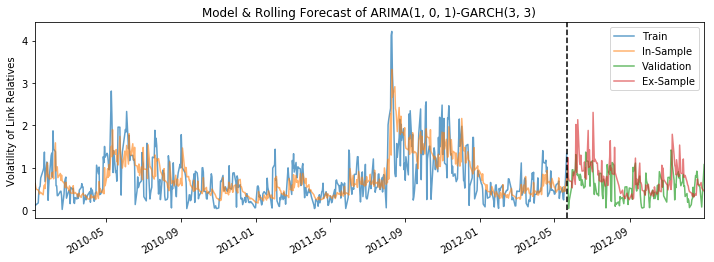

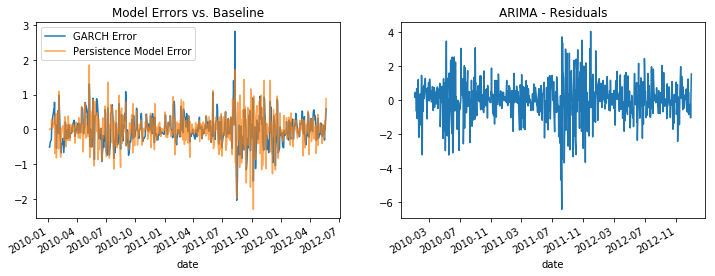

time: 906 ms


In [610]:
ax = gspc_train_volatility.plot(label='Train', alpha=0.7, title=f'Model & Rolling Forecast of {final_model}', figsize=(12, 4))
ax.plot(gspc_train.index, in_sample_predictions, label='In-Sample', alpha=0.6)
gspc_val_volatility.plot(ax=ax, label='Validation', alpha=0.7)
ex_sample_predictions.plot(ax=ax, label='Ex-Sample', alpha=0.6)
plt.xlim((gspc_train.index[0], gspc_val.index[-1]))
plt.axvline(gspc_val.index[0], color='black', linestyle='dashed')
ax.legend()
ax.set_ylabel('Volatility of Link Relatives')
ax.set_xlabel('')
# plt.gcf().savefig(f'gspc - {model}.pdf')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
final_model.arima_fit.resid.plot(ax=axes[1])
axes[1].set_title('ARIMA - Residuals')

print(f'GARCH({p}, {q}), RMS = ', round(np.sqrt(mean_squared_error(gspc_train_volatility, in_sample_predictions)), 4))
print('Persistence Model, RMS = ', round(np.sqrt(mean_squared_error(gspc_train_volatility, gspc_train_volatility.shift(1).fillna(0))), 4))

(gspc_train_volatility - in_sample_predictions).plot(ax=axes[0], label='GARCH Error')
axes[0].plot(gspc_train_volatility - gspc_train_volatility.shift(1), alpha=0.7, label='Persistence Model Error')
axes[0].legend()
axes[0].set_title('Model Errors vs. Baseline');

# GARCH(15, 15), RMS =  0.2344
# Persistence Model, RMS =  0.0981

### TO READ
- https://shishirshakya.blogspot.com/2015/06/the-todayamamoto-approach-to-granger.html
- On Plotting https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

In [ ]:
def inspect_forecast(model_fit, train, val):
    # multi-step out-of-sample forecast
    start_index = len(train)
    end_index = start_index + len(val) - 1
    ex_sample_forecast = model_fit.predict(start=start_index, end=end_index)
    ex_sample_forecast.index = val.index

    in_sample_forecast = model_fit.predict(len(train)-101, len(train)-1)

    plt.plot(train.iloc[-100:])
    plt.plot(val, 'b--', alpha=0.2)
    plt.plot(in_sample_forecast, color='orange', alpha=0.2)
    plt.plot(ex_sample_forecast, color='orange')

inspect_forecast(model_fit, train, val)